In [57]:
import random
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [9]:
# Cell 1 from notebook

import numpy as np

def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    
    grad_ui = reg * Ui - (Yij - np.dot(Ui, Vj)) * Vj
    return grad_ui * eta

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    grad_vj = reg * Vj - (Yij - np.dot(Ui, Vj)) * Ui
    return grad_vj * eta

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    U_Fro_2 = 0
    for i in range(U.shape[0]):
        for j in range(U.shape[1]):
            val = U[i, j]
            U_Fro_2 += val ** 2
        
    V_Fro_2 = 0
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            val = V[i, j]
            V_Fro_2 += val ** 2
        
    grad_sum = 0
    for i in range(Y.shape[0]):
        grad_sum += (Y[i, 2] - np.dot(U[Y[i, 0] - 1, :], V[Y[i, 1] - 1, :])) ** 2
            
    err = reg / 2 * (U_Fro_2 + V_Fro_2) + grad_sum / 2
    
    return err / len(Y)


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    
    U = np.random.rand(M, K) - 0.5
    V = np.random.rand(N, K) - 0.5
    oldloss = get_err(U, V, Y, reg)
        
    for e in range(max_epochs):
        idx = np.random.permutation(Y.shape[0])
        for index in idx:
            i = Y[index, 0] - 1
            j = Y[index, 1] - 1
            Y_ij = Y[index, 2]
            U[i, :] -= grad_U(U[i, :], Y_ij, V[j, :], reg, eta)
            V[j, :] -= grad_V(V[j, :], Y_ij, U[i, :], reg, eta)
            
        new_loss = get_err(U, V, Y, reg)
        if (e == 0):
            loss2 = new_loss
        elif ((loss - new_loss) / (oldloss - loss2) < eps):
            loss = new_loss
            break
        loss = new_loss
    
    print(e)
    return (U, V, loss)

In [10]:
# Cell 2 from notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas
import csv

with open("data/movies.txt","r", encoding="latin_1") as f:
    reader = csv.reader(f, delimiter="\t")
    
    # Put the contents in a matrix
    movies = np.array(list(reader))


# Cell 3 from notebook

Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
k = 20
reg = 10**-1
eta = 0.03 # learning rate

U,V, e_in = train_model(M, N, k, eta, reg, Y_train)

19


In [11]:
U, V = U.T, V.T
print(np.shape(U))
print(np.shape(V))

(20, 943)
(20, 1682)


In [12]:
def get_projection(U, V):
    A, Sig, B = np.linalg.svd(V)
    u_tilda = np.matmul(A[:,0:2].T, U)
    v_tilda = np.matmul(A[:,0:2].T, V)
    return u_tilda, v_tilda

In [13]:
U_tilda, V_tilda = get_projection(U, V)

In [16]:
print(np.shape(U_tilda))
print(np.shape(V_tilda))
print(V_tilda)

(2, 943)
(2, 1682)
[[-2.05983793 -1.63561529 -1.49424268 ... -0.46327317 -1.4135877
  -1.26243407]
 [-0.28486483 -0.4663474  -0.19374533 ... -0.21236633  0.36375258
   0.36521323]]


In [58]:
'''
    movies: indices of the movies (movie_id - 1)
'''
def create_visualization(movies_inds):
    x_data = [V_tilda[0][i] for i in movies_inds]
    y_data = [V_tilda[1][i] for i in movies_inds]
    group = [movies[i][1] for i in movies_inds]

    # Create dataframe
    df = pd.DataFrame({
    'x': x_data,
    'y': y_data,
    'group': group
    })

    # basic plot
    sns.set_style("whitegrid")
    p1=sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':40})

    # add annotations one by one with a loop
    for line in range(0,df.shape[0]):
         p1.text(df.x[line]+0.04, df.y[line], df.group[line], horizontalalignment='left', 
                 size='small', color='black', weight='semibold')


    # see it
    plt.rcParams["figure.figsize"] = (8, 4)
    plt.show()

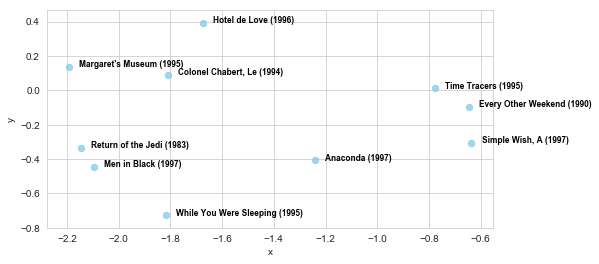

In [59]:
# Ten movies of your choice:
rand_movies = random.sample(range(0, 1682), 10)
create_visualization(rand_movies)

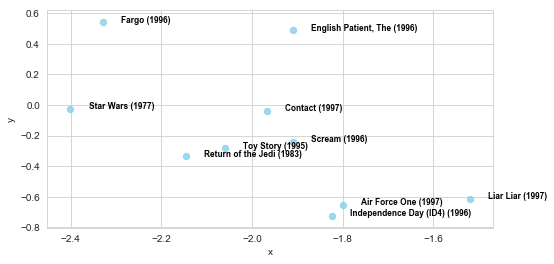

In [60]:
# Ten most popular movies:
popular = [120, 299,   0, 287, 285, 293, 180,  99, 257,  49]
create_visualization(popular)

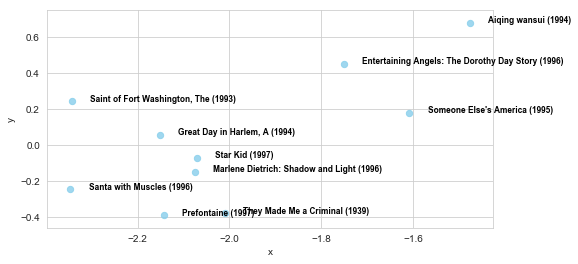

In [61]:
# Ten best movies:
best = [1535, 1499, 1188, 1200, 1598, 1121,  813, 1652, 1466, 1292]
create_visualization(best)

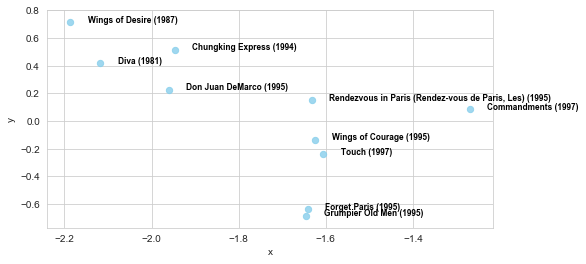

In [69]:
# Ten movies from Romance:
romance = []
for i in range(len(movies)):
    if movies[i][16] == '1':
        romance.append(int(movies[i][0])-1)
rand_rom = random.sample(romance, 10)
create_visualization(rand_rom)

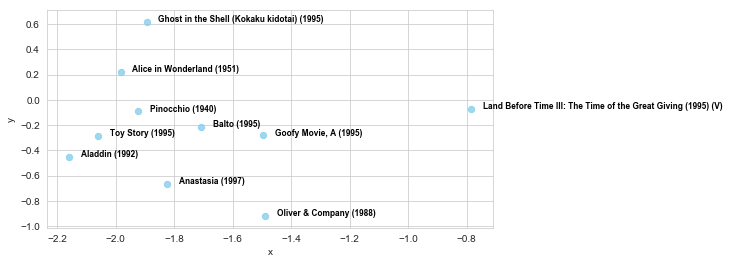

In [71]:
# Ten movies from Animation:
animation = []
for i in range(len(movies)):
    if movies[i][5] == '1':
        animation.append(int(movies[i][0])-1)

rand_anim = random.sample(animation, 10)
create_visualization(rand_anim)

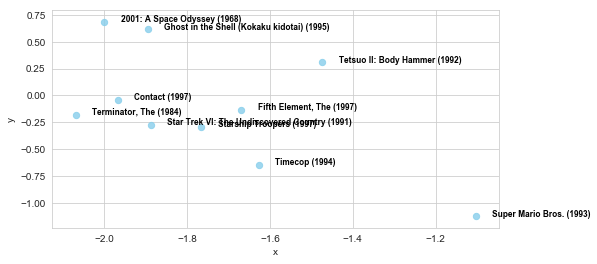

In [68]:
# Ten movies from Sci-Fi:
scifi = []
for i in range(len(movies)):
    if movies[i][17] == '1':
        scifi.append(int(movies[i][0])-1)

rand_sf = random.sample(scifi, 10)
create_visualization(rand_sf)